In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import scipy
import time
import gget
from sklearn.decomposition import PCA
from kneed import KneeLocator
from importlib import reload

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.patheffects as pe

"""WARNING: disabling future warnings"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # and to omit tensorflow logging

""" Increase scanpy output"""
sc.settings.verbosity = 3

# local 
import utils as ut
reload(ut)

<module 'utils' from '/home/cstansbu/git_repositories/MC3R/notebooks/utils.py'>

In [2]:
fullpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/processed_data/all_clustered.h5ad"
raw = sc.read(fullpath)
pdf = raw.copy()
pdf

AnnData object with n_obs × n_vars = 42937 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes', 'color', 'leiden', 'cluster_num', 'Cluster', 'cluster_cat', 'U1', 'U2', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cluster', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

cell_type
Neurons             33647
Oligodendrocytes     4026
Astrocytes           2121
OPC                   911
Fibroblasts           840
Microglia             828
Ependymal Cells       564
Name: count, dtype: int64
saved: /nfs/turbo/umms-indikar/shared/projects/MC3R/analysis_files/figures/cluster_umap.png


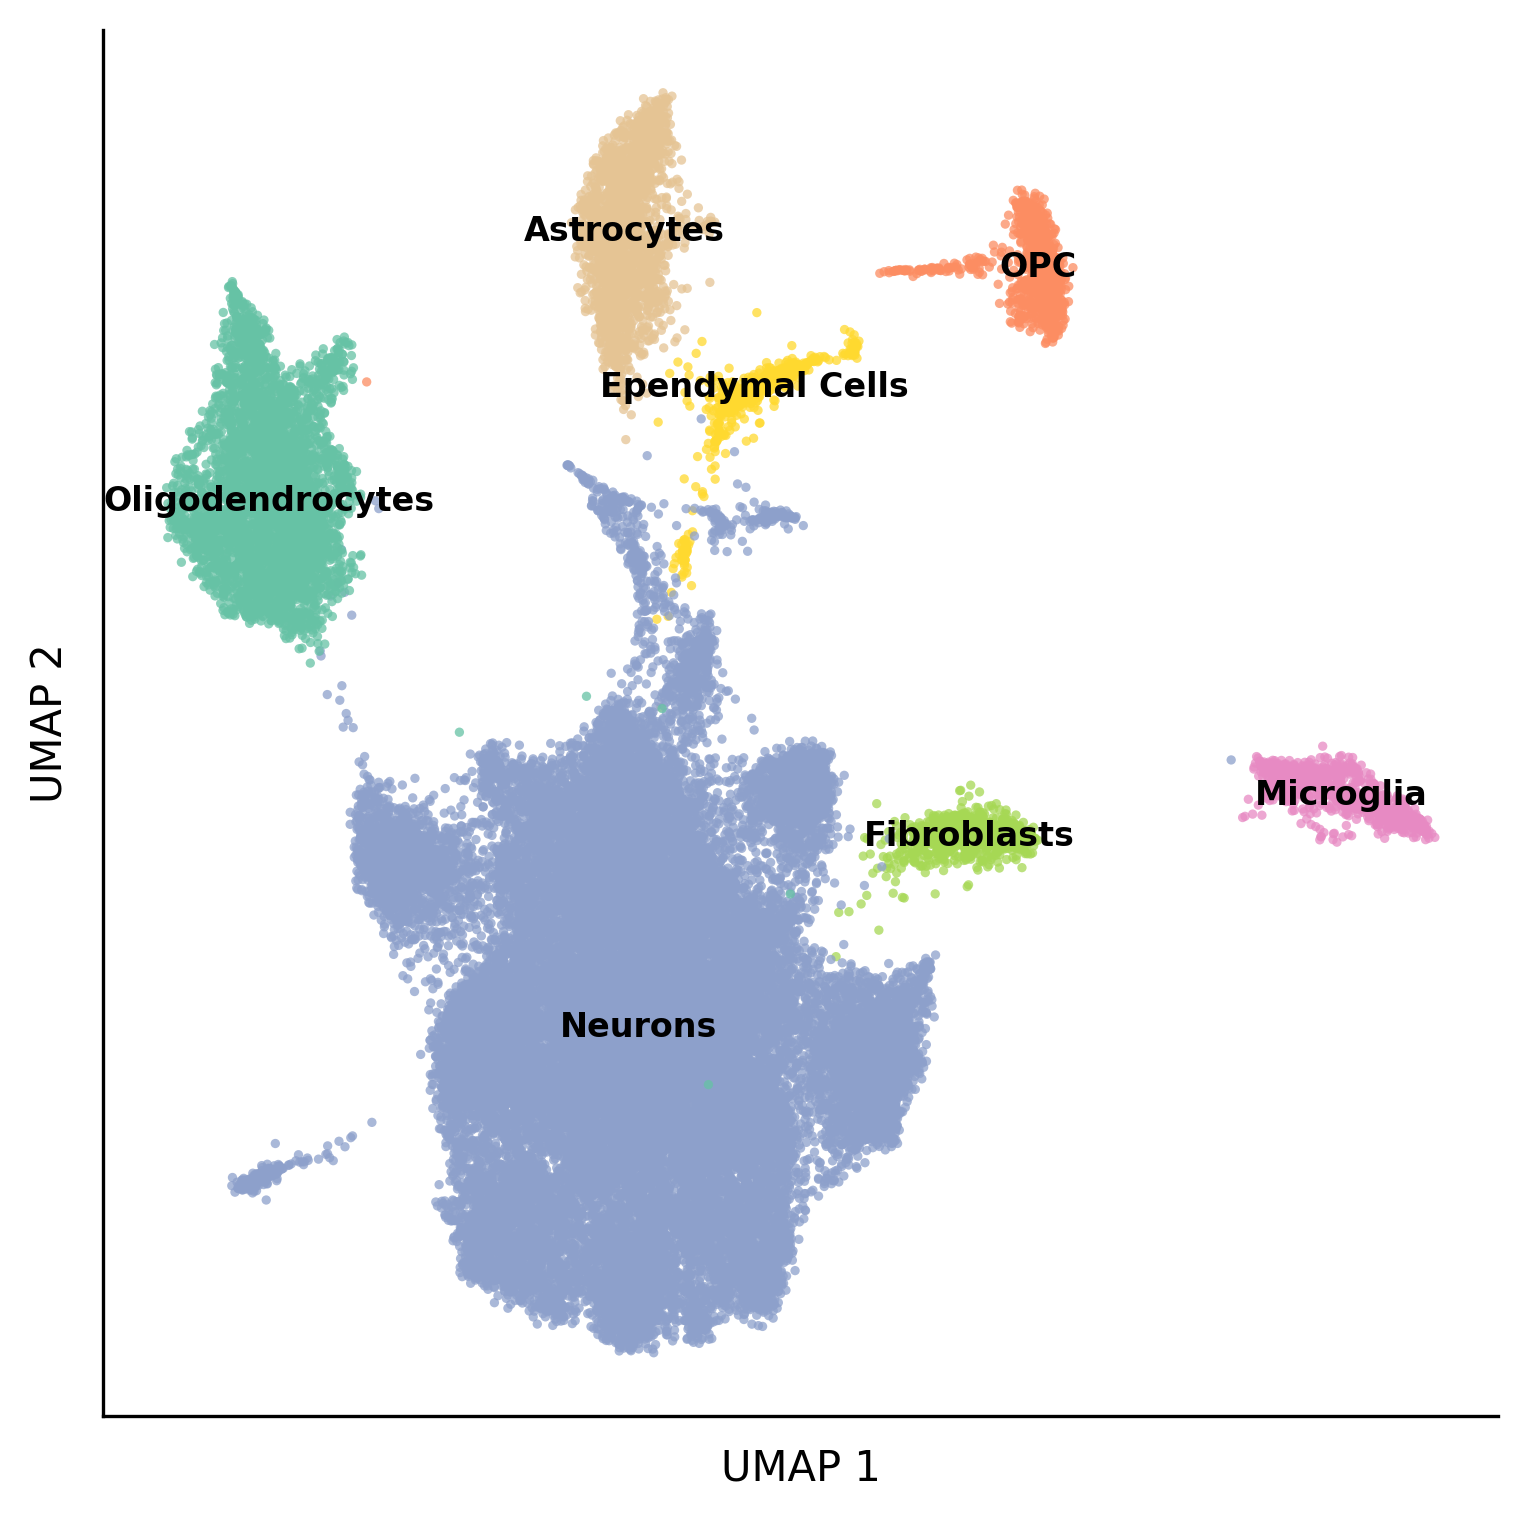

In [3]:
cluster_map = {
    "C1" : "Neurons",
    "C2" : "Oligodendrocytes",
    "C3" : "Neurons",
    "C4" : "Astrocytes",
    "C5" : "Neurons",
    "C6" : "Neurons",
    "C7" : "OPC",
    "C8" : "Neurons",
    "C9" : "Fibroblasts",
    "C10" : "Microglia",
    "C11" : "Ependymal Cells",
    "C12" : "Neurons",
}

pdf.obs['cell_type'] = pdf.obs['Cluster'].map(cluster_map)
print(pdf.obs['cell_type'].value_counts())


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6

# sort the data frame
pdx = pdf.obs.copy()
pdx = pdx.sort_values(by='cell_type')


sns.scatterplot(data=pdx,
                x='U1',
                y='U2',
                hue='cell_type',
                palette='Set2_r',
                s=5,
                alpha=0.75,
                ec='none'
        )

sns.despine()
plt.xticks([])
plt.yticks([])

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# label on data
ax = plt.gca()

all_pos = (
        pdx.groupby('cell_type')[['U1', 'U2']]
        .median()
        .sort_index()
    )

for label, x_pos, y_pos in all_pos.itertuples():
    ax.text(
        x_pos,
        y_pos,
        label,
        weight='bold',
        verticalalignment="center",
        horizontalalignment="center",
        fontsize='8',
    )

plt.gca().legend().remove()

outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/analysis_files/figures/cluster_umap.png"
plt.savefig(outpath)
print(f"saved: {outpath}")

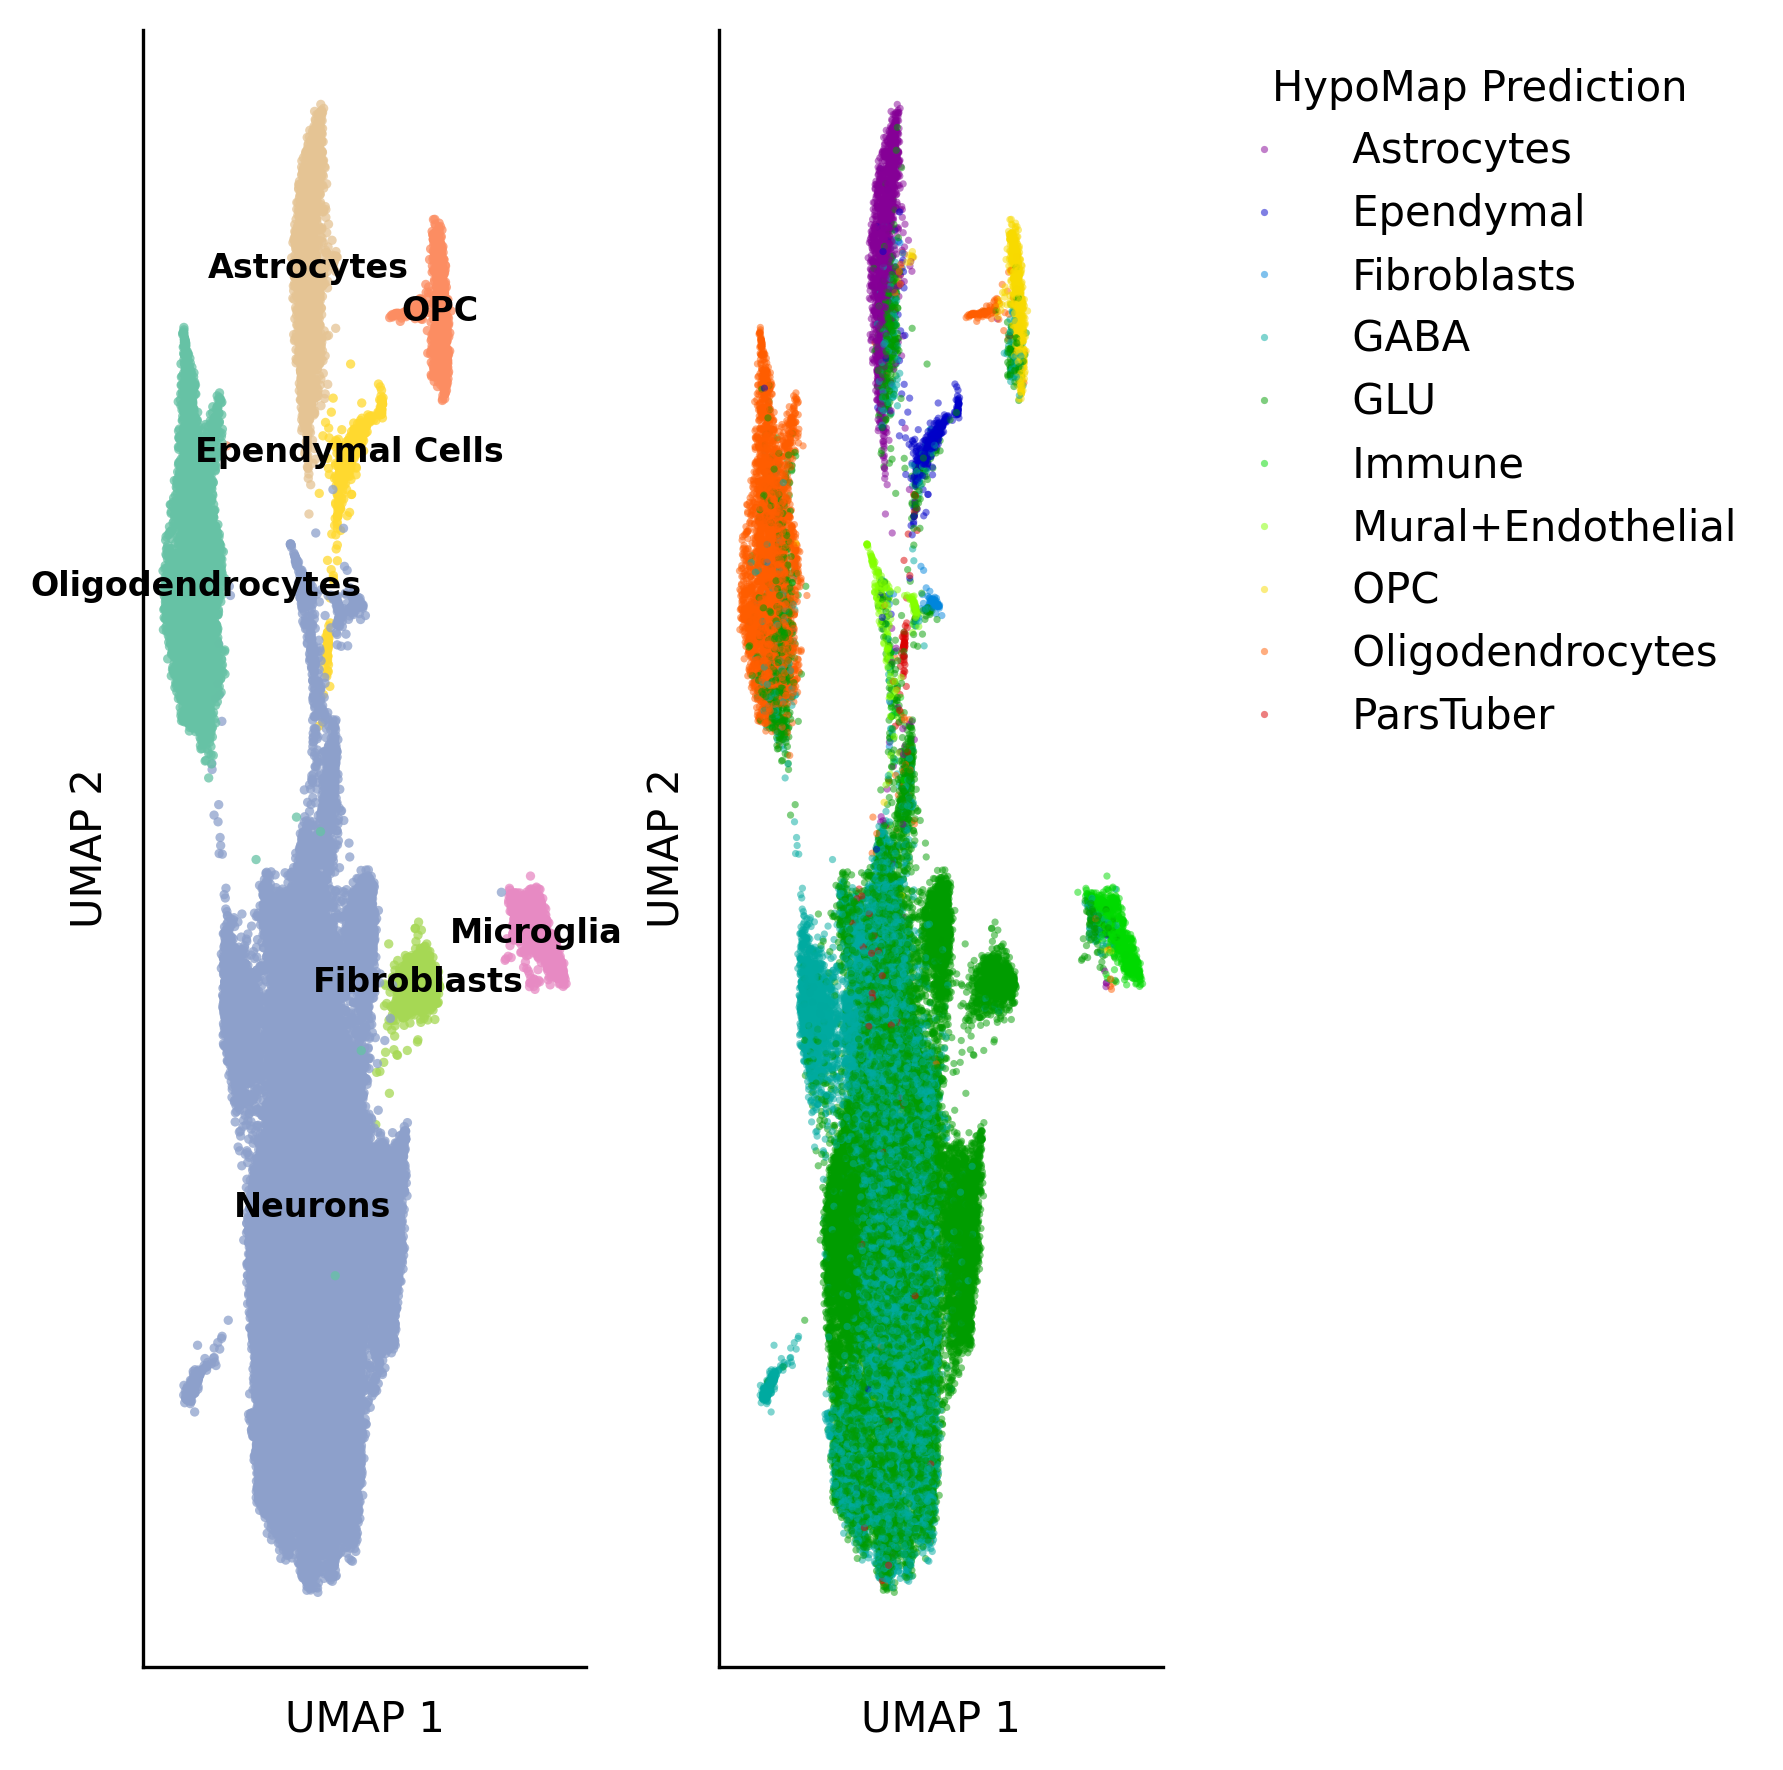

In [4]:
fig, axs = plt.subplots(1, 2)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 4

# sort the data frame
pdx = pdf.obs.copy()
pdx = pdx.sort_values(by='cell_type')


sns.scatterplot(data=pdx,
                x='U1',
                y='U2',
                hue='cell_type',
                palette='Set2_r',
                s=5,
                alpha=0.75,
                ax=axs[0],
                ec='none'
        )

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")

# label on data
all_pos = (
        pdx.groupby('cell_type')[['U1', 'U2']]
        .median()
        .sort_index()
    )

for label, x_pos, y_pos in all_pos.itertuples():
    axs[0].text(
        x_pos,
        y_pos,
        label,
        weight='bold',
        verticalalignment="center",
        horizontalalignment="center",
        fontsize='8',
    )

axs[0].legend().remove()

sns.scatterplot(pdx,
                x='U1',
                y='U2',
                hue='broad_type',
                palette='nipy_spectral',
                linewidth=0.25,
                alpha=0.5,
                ax=axs[1],
                s=3,
                ec='none')

axs[1].set_yticks([])
axs[1].set_xticks([])
axs[1].set_ylabel("UMAP 2")
axs[1].set_xlabel("UMAP 1")

sns.move_legend(axs[1],
                loc='upper left',
                frameon=False,
                title='HypoMap Prediction',
                bbox_to_anchor=(1.05, 1))

sns.despine()
plt.tight_layout()

# outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/analysis_files/figures/cluster_umap_vs_hypomap.png"
# plt.savefig(outpath)
# print(f"saved: {outpath}")

,batch,reference_embedding_C7_named,reference_embedding_C25_named,C25_named,C7_named,reference_embedding_C7_named_clean,reference_embedding_C25_named_clean,C25_named_clean,C7_named_clean,UMAP1,...,n_genes,color,leiden,cluster_num,Cluster,cluster_cat,U1,U2,cell_type,Sample
AAACCCACATGGCTGC-1_fasted_m,fasted_m,C7-2: GABA,C25-11: GABA-1,C25-10: GABA-2,C7-2: GABA,GABA,GABA-1,GABA-2,GABA,-6.741960,...,3847,#fdbf6f,0,1,C1,C1,0.388993,-1.124416,Neurons,Male (fasted)
AAACCCAGTATATGGA-1_fasted_m,fasted_m,C7-2: GABA,C25-13: GABA-4,C25-1: GLU-1,C7-2: GABA,GABA,GABA-4,GLU-1,GABA,2.378481,...,4724,#fdbf6f,4,5,C5,C5,-3.683469,0.917572,Neurons,Male (fasted)
AAACCCAGTCAACACT-1_fasted_m,fasted_m,C7-5: Immune,C25-21: Immune,C25-21: Immune,C7-5: Immune,Immune,Immune,Immune,Immune,1.525248,...,1116,#f1f9a9,9,10,C10,C10,11.963770,2.797825,Microglia,Male (fasted)
AAACCCATCCCGTGAG-1_fasted_m,fasted_m,C7-4: Oligo+Precursor,C25-19: Oligodendrocytes,C25-19: Oligodendrocytes,C7-4: Oligo+Precursor,Oligo+Precursor,Oligodendrocytes,Oligodendrocytes,Oligo+Precursor,15.965842,...,1311,#378ebb,1,2,C2,C2,-6.948169,6.372647,Oligodendrocytes,Male (fasted)
AAACCCATCGAACTCA-1_fasted_m,fasted_m,C7-1: GLU,C25-2: GLU-2,C25-2: GLU-2,C7-1: GLU,GLU,GLU-2,GLU-2,GLU,-2.045243,...,4176,#feeda1,0,1,C1,C1,0.037044,1.440031,Neurons,Male (fasted)


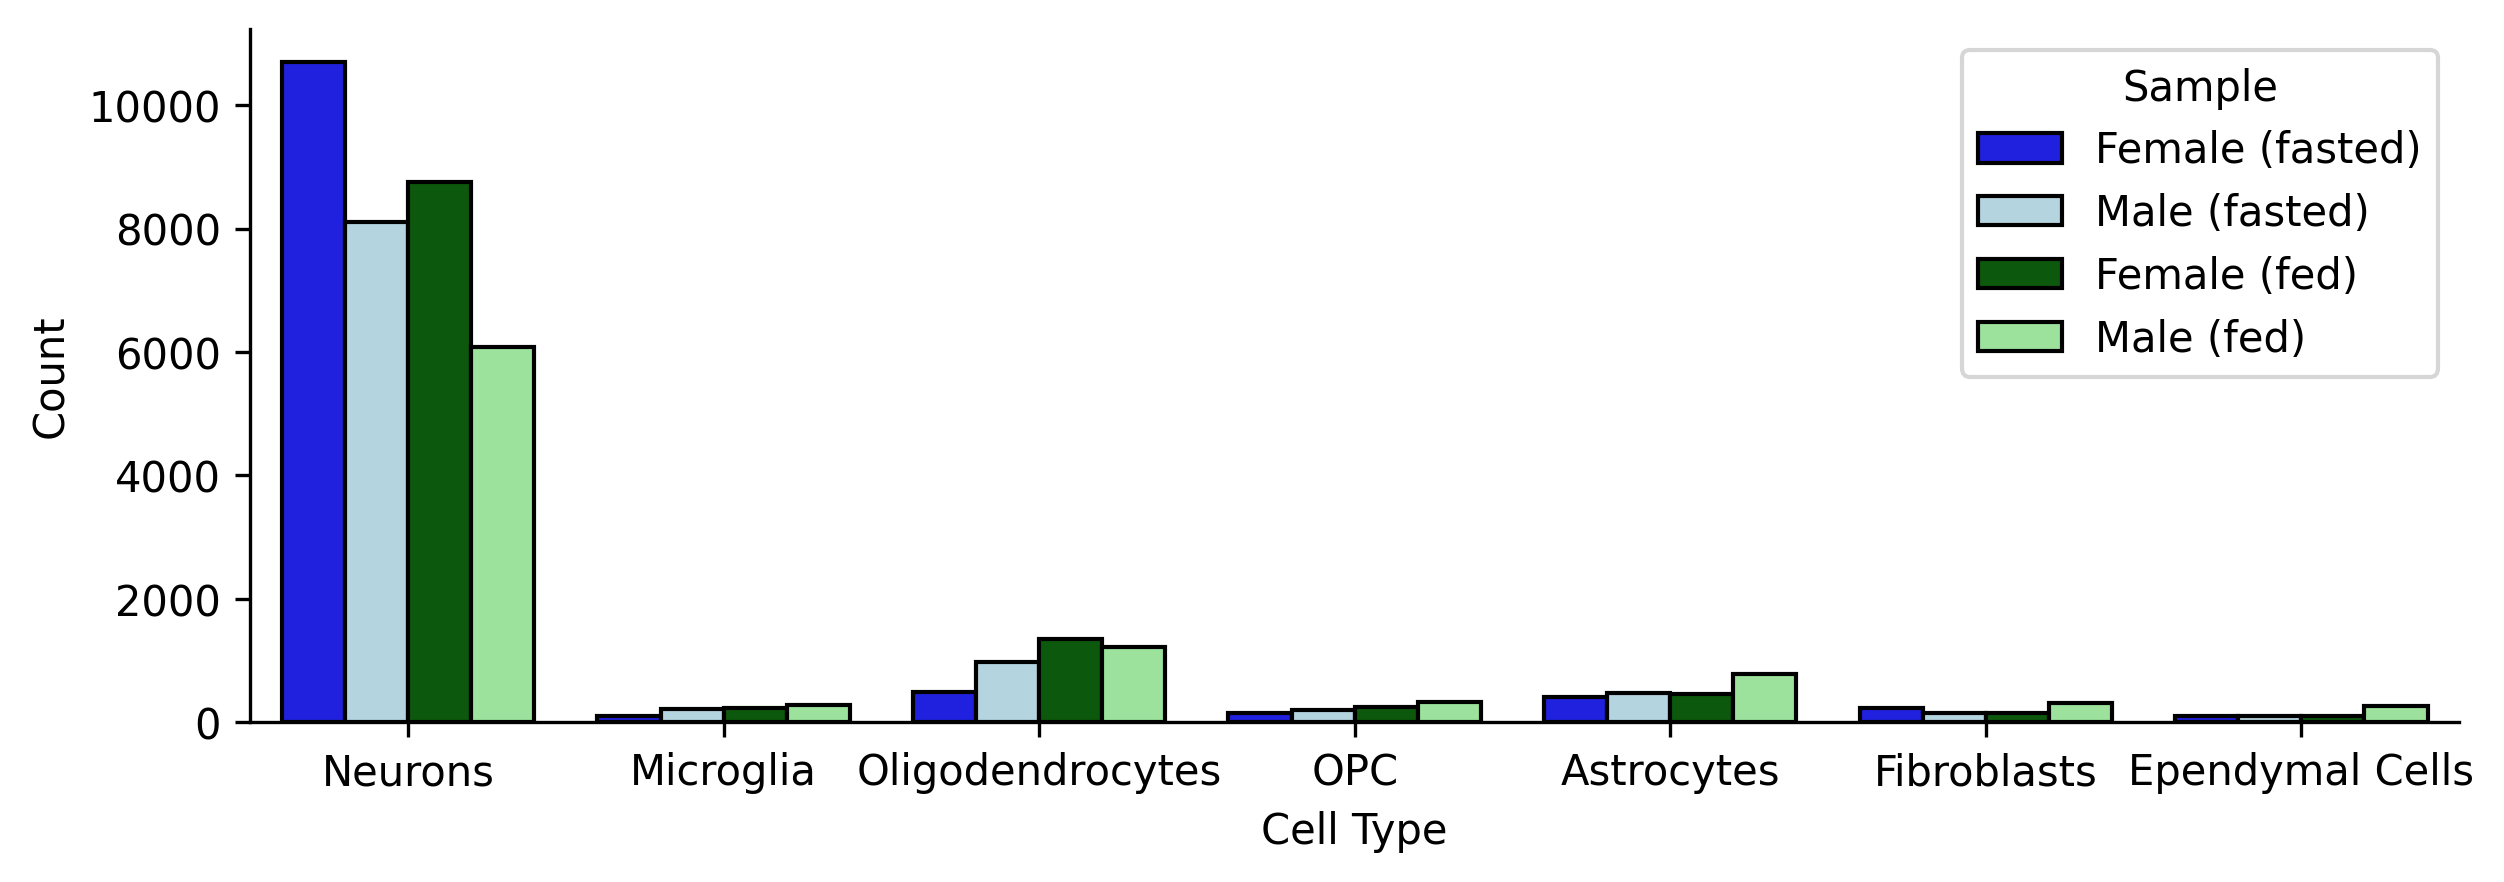

In [5]:
# Set plot configuration once outside the function
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9.5, 3

pdx = pdf.obs.copy()

batch_map = {
    'fasted_f' : 'Female (fasted)',
    'fasted_m' : 'Male (fasted)',
    'fed_f' : 'Female (fed)',
    'fed_m' : 'Male (fed)',
}

pdx['Sample'] = pdx['batch'].map(batch_map)

sns.countplot(data=pdx, 
              x='cell_type', 
              hue='Sample',
              ec='k',
              palette=['blue', 'lightblue', 'darkgreen', 'lightgreen'])

plt.xlabel("Cell Type")
plt.ylabel("Count")
sns.despine()
# plt.xticks(rotation=45)

pdx.head()

In [6]:
gx = pdx.groupby(['cell_type', 'Sex', 'Diet'])['batch'].count().reset_index()
gx.columns = ['CellType', 'Sex', 'Diet', 'CellCount']

outpath = "data/cell_counts.csv"
gx.to_csv(outpath, index=False)
gx.head()

,CellType,Sex,Diet,CellCount
0,Astrocytes,f,fasted,408
1,Astrocytes,f,fed,459
2,Astrocytes,m,fasted,473
3,Astrocytes,m,fed,781
4,Ependymal Cells,f,fasted,95


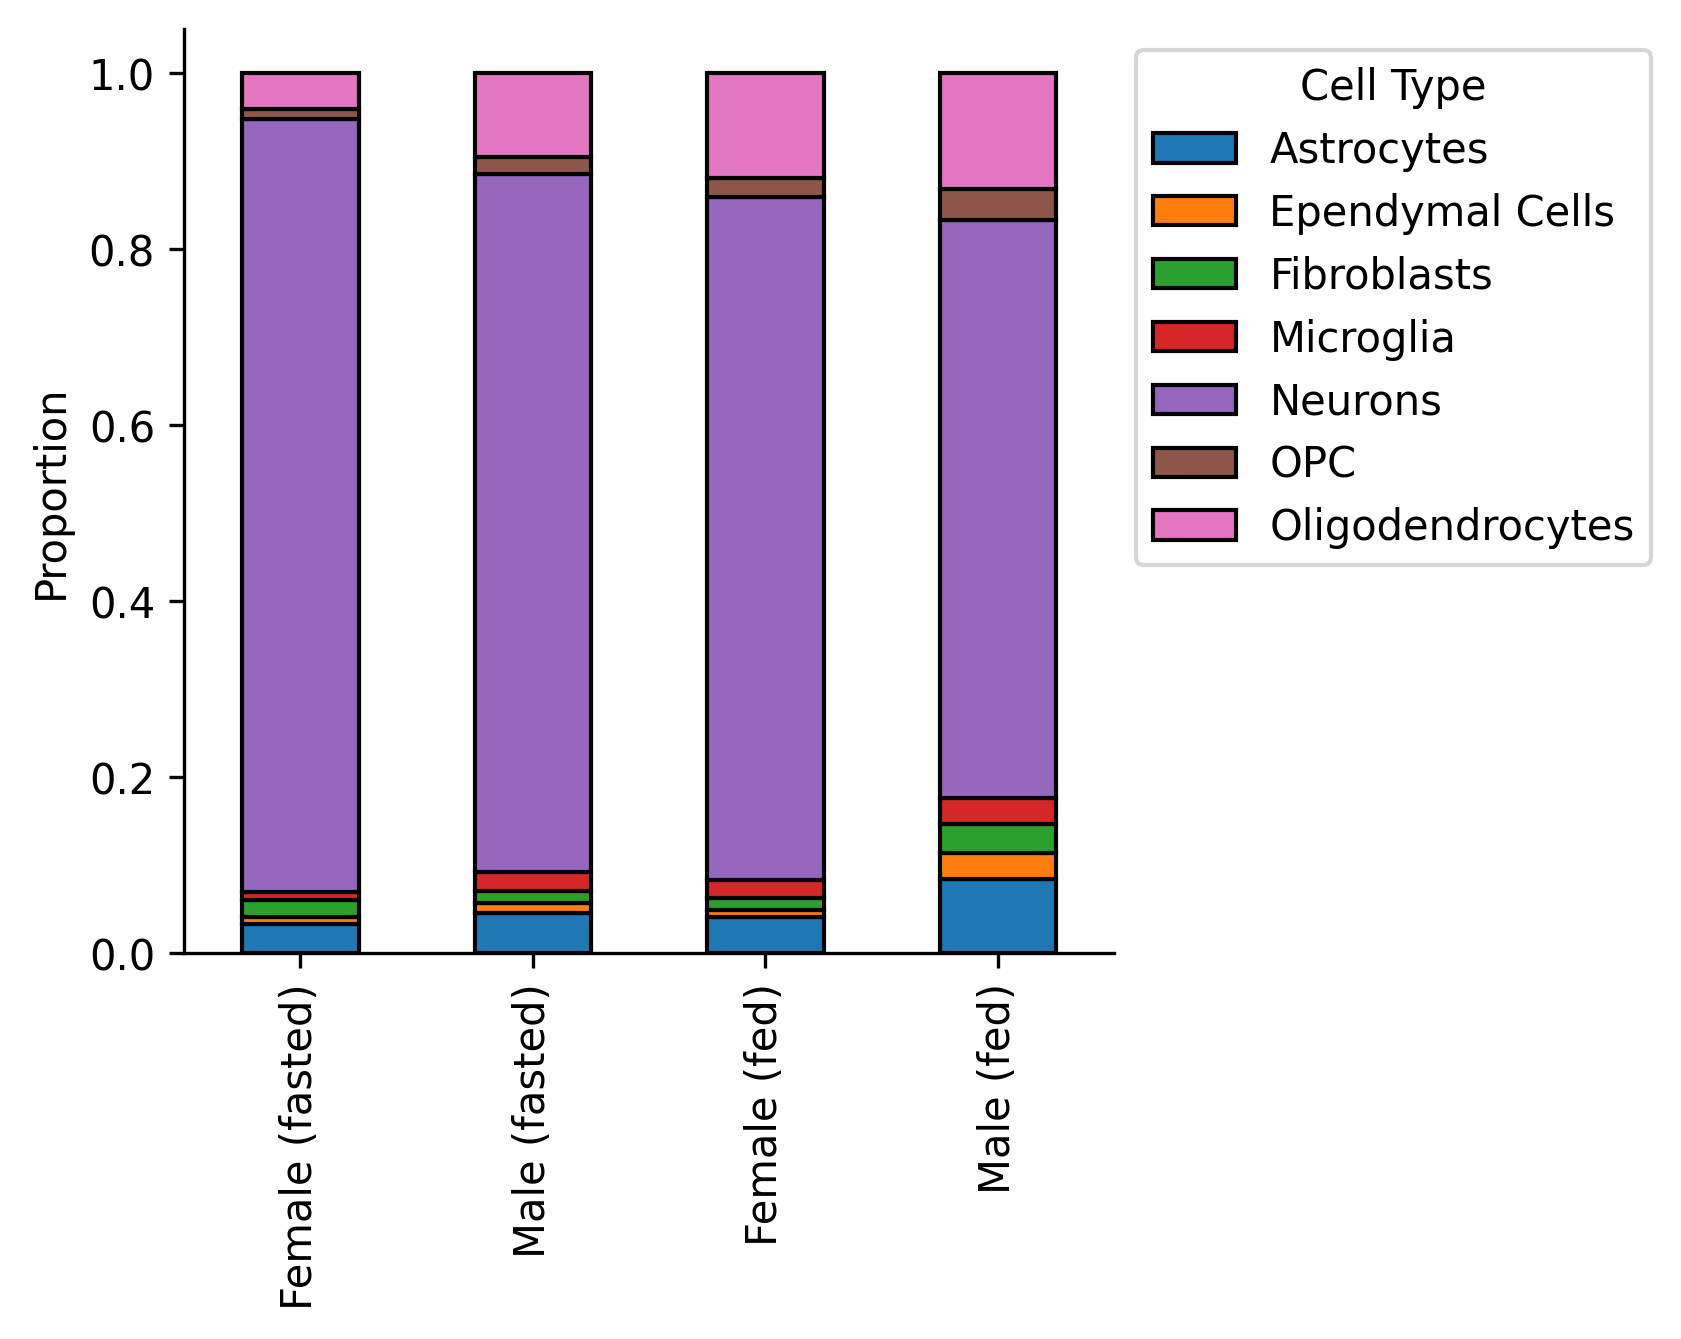

In [7]:
# Set plot configuration once outside the function
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9.5, 3

pdx = pdf.obs.copy()

batch_map = {
    'fasted_f' : 'Female (fasted)',
    'fasted_m' : 'Male (fasted)',
    'fed_f' : 'Female (fed)',
    'fed_m' : 'Male (fed)',
}

pdx['Sample'] = pdx['batch'].map(batch_map)

# Calculate proportions
proportions = (pdx.groupby(['cell_type', 'Sample']).size() / pdx.groupby('Sample').size())

# Reshape proportions for plotting
proportions = proportions.unstack().T

# Plotting
# Set plot configuration once outside the function
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4
proportions.plot(kind='bar', stacked=True, ec='k')

plt.xlabel("")
plt.ylabel("Proportion")
sns.despine()
sns.move_legend(plt.gca(), 
                title='Cell Type',
                loc='upper right',
                bbox_to_anchor=(1.6,1))

# # # Plotting
# sns.barplot(data=proportions, 
#             x='Sample', 
#             y='Proportion', 
#             hue='cell_type', 
#             palette=['blue', 'lightblue', 'darkgreen', 'lightgreen'], 
#             edgecolor='k')
# plt.xlabel("Cell Type")
# plt.ylabel("Proportion")
# plt.title("Proportion of Total Cell Type by Sample")
# sns.despine()
# plt.xticks(rotation=45)
# plt.show()

/tmp/ipykernel_3487291/3179683530.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, shrink=0.4)


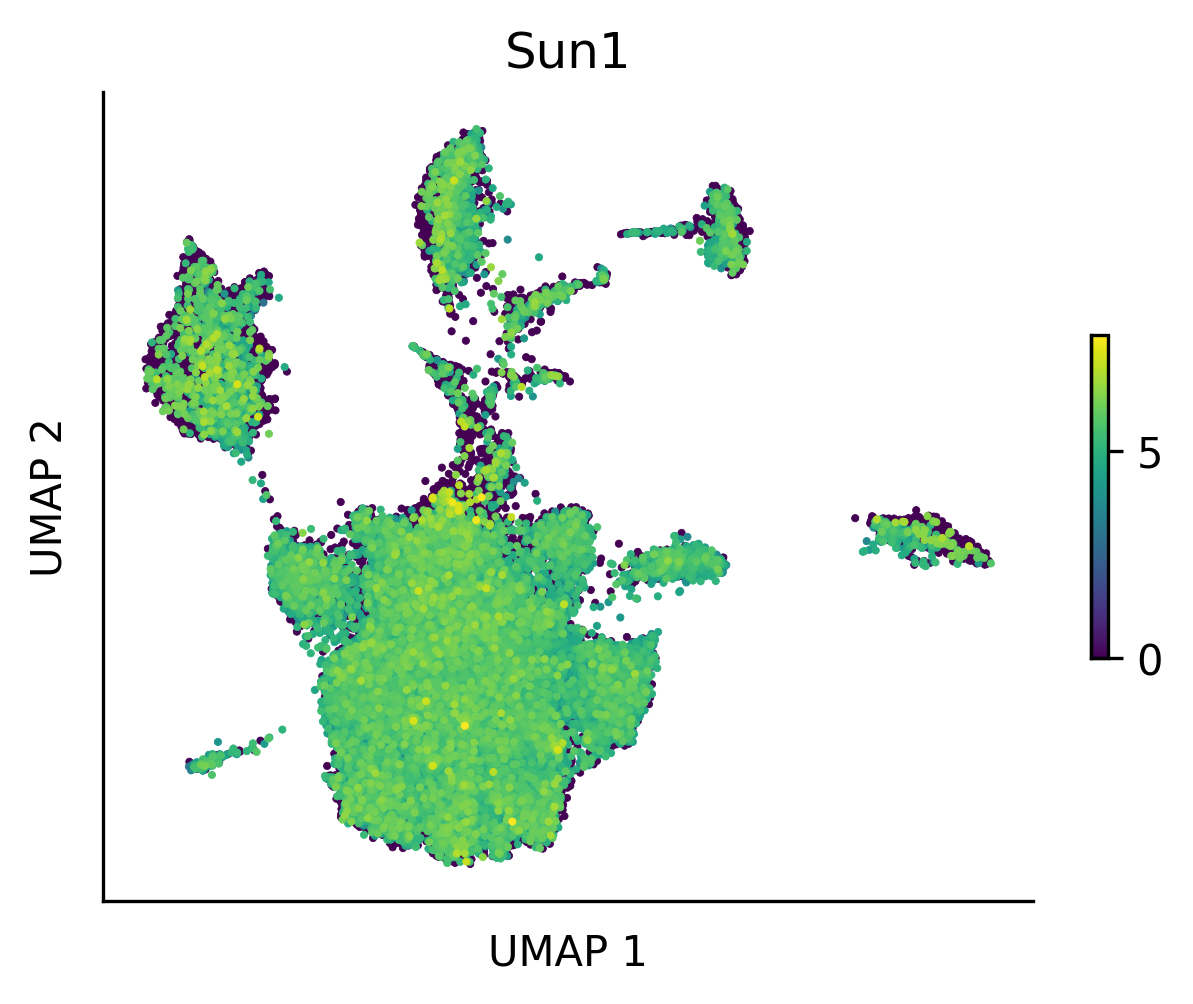

In [8]:
def plot_umap_scatter(pdf, color="Sun1", cmap='viridis', **kwargs):
    """
    Creates a scatterplot of UMAP data with custom color mapping and a colorbar.
    
    Args:
      pdf (pd.DataFrame): DataFrame containing UMAP data.
      color (str, optional): Column name for color mapping. Defaults to "Sun1".
      **kwargs (dict, optional): Additional keyword arguments for scatterplot customization.
    
    """
    
    # Extract color values from UMAP data
    v = pdf[:, [color]].X.todense()
    gdf = pdf.obs.copy()
    
    # Add color values as a new column and sort data
    gdf['exp'] = np.ravel(v)
    order = np.argsort(gdf['exp'])
    
    # Create the scatterplot with colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(min(v), max(v)))
    sm.set_array([])
    p = plt.scatter(gdf['U1'][order], 
                  gdf['U2'][order], 
                  c=gdf['exp'][order], 
                  **kwargs)  # Apply kwargs
    
    plt.colorbar(sm, shrink=0.4)
    
    # Additional plot formatting
    sns.despine()
    plt.yticks([])
    plt.xticks([])
    plt.ylabel("UMAP 2")
    plt.xlabel("UMAP 1")
    plt.title(color)
    
    return p  # Return the scatterplot object


# Set plot configuration once outside the function
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3.5

# Call the plotting function with additional kwargs
p = plot_umap_scatter(pdf, color="Sun1", s=3, linewidths=0.2)


/tmp/ipykernel_3487291/3179683530.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, shrink=0.4)


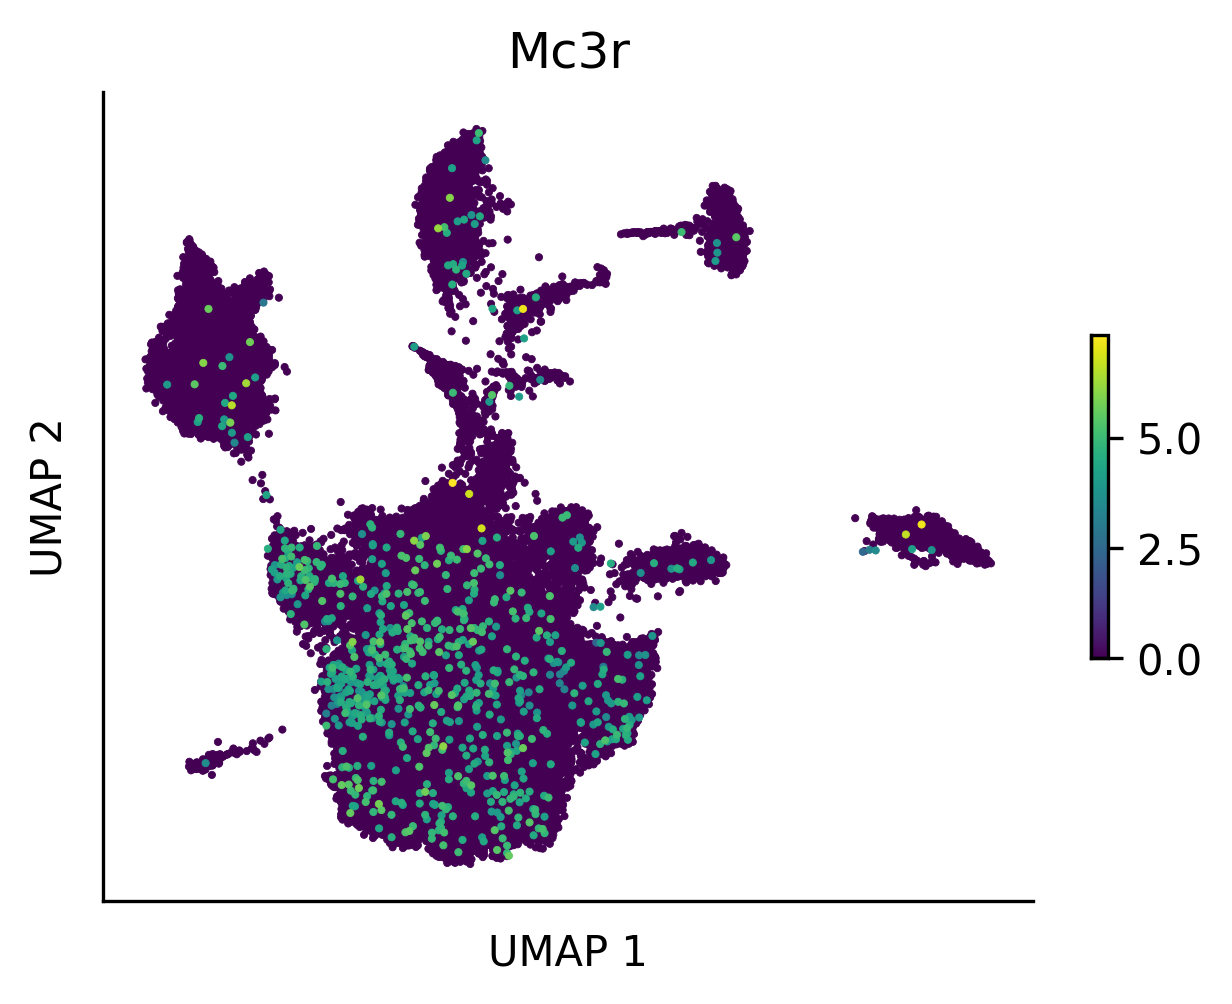

In [9]:
p = plot_umap_scatter(pdf, color="Mc3r", s=3, linewidths=0.2)

# Key genes

In [10]:
label_genes = [
    "Agrp", "Acvr1c", "Adcyap1", "Bdnf", "Cartpt", "Coch", "Crabp1", "Dlk1",
    "Drd2", "Esr1", "Fezf1", "Foxp2", "Gal", "Gabra2", "Gabra5", "Ghrh", "Ghrhr",
    "Grik1", "Grik3", "Gnrh1", "Gnrhr", "Glp1r", "Lepr", "Mc3r", "Mc4r",
    "Mt2", "Nr5a1", "Nfib", "Nts", "Otp", "Oxtr", "Pak3", "Plk2", "Pnoc", "Pomc",
    "Ptk2b", "Rprm", "Sst", "Syndig1", "Tac1", "Tac2", "Trh"
]


images = []

for gene in label_genes:

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 5, 3.5
    p = plot_umap_scatter(pdf, color=gene, s=3, linewidths=0.2)
    fig = plt.gcf()
    img = ut.fig2img(fig)
    images.append(img)
    # plt.show()
    plt.clf()
   
outpath = f"/home/cstansbu/git_repositories/MC3R/analysis/all_clusters_key_genes.pdf"

images[0].save(
    outpath, 
    "PDF" ,
    resolution=100.0, 
    save_all=True, 
    append_images=images[1:]
)

print(f"saved: {outpath}") 

/tmp/ipykernel_3487291/3179683530.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, shrink=0.4)
/tmp/ipykernel_3487291/3179683530.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, shrink=0.4)
/tmp/ipykernel_3487291/3179683530.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *map

saved: /home/cstansbu/git_repositories/MC3R/analysis/all_clusters_key_genes.pdf


<Figure size 1500x1050 with 0 Axes>

# marker genes 

In [11]:
label_genes = [
    'Slc1a2','Slc7a10','Slc39a12','Itih3',
    'Gad1','Gad2','Gabbr2','Grin2b',
    'Slc17a6','Aim2','P2rx7','Il10ra',
    'Kif13b','Ninj2','Sec14l5', 'Drd2', 
    'Mest',
]

images = []

for gene in label_genes:

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 5, 3.5
    p = plot_umap_scatter(pdf, color=gene, s=3, linewidths=0.2)
    fig = plt.gcf()
    img = ut.fig2img(fig)
    images.append(img)
    # plt.show()
    plt.clf()
   
outpath = f"/home/cstansbu/git_repositories/MC3R/analysis/all_clusters_marker_genes.pdf"

images[0].save(
    outpath, 
    "PDF" ,
    resolution=100.0, 
    save_all=True, 
    append_images=images[1:]
)

print(f"saved: {outpath}") 


/tmp/ipykernel_3487291/3179683530.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, shrink=0.4)
/tmp/ipykernel_3487291/3179683530.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, shrink=0.4)
/tmp/ipykernel_3487291/3179683530.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *map

saved: /home/cstansbu/git_repositories/MC3R/analysis/all_clusters_marker_genes.pdf


<Figure size 1500x1050 with 0 Axes>

# DEG

In [12]:
key = 'cell_type'

# get marker genes
sc.tl.rank_genes_groups(pdf, 
                        groupby=key,
                        method='wilcoxon',
                        key_added=key,
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(pdf, 
                                  group=None,
                                  key=key)

deg.head()

ranking genes


... storing 'cell_type' as categorical


    finished: added to `.uns['cell_type']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:04:29)


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,Astrocytes,Slc4a4,75.261253,10.219913,0.0,0.0
1,Astrocytes,Gm3764,74.505028,9.686487,0.0,0.0
2,Astrocytes,Apoe,74.059898,7.495738,0.0,0.0
3,Astrocytes,Slc1a2,73.462112,8.312918,0.0,0.0
4,Astrocytes,Atp1a2,72.644928,9.749494,0.0,0.0


In [13]:
def get_top_genes(deg, n_genes=3, lft=1.5, alpha=0.01):
    """A function to get the top deg from
    each cluster"""
    
    sig = deg[deg['logfoldchanges'] > lft]
    sig = sig[sig['pvals_adj'] <= alpha]

    # filter out predicted genes
    sig = sig[~sig['names'].str.startswith("Gm")]
    sig = sig[~sig['names'].str.endswith("Rik")]
    
    sig = sig.sort_values(by=['group', 'logfoldchanges'], ascending=[False, False])

    res = []

    for cluster, group in sig.groupby('group'):
        group = group.head(n_genes)
        genes = ", ".join(group['names'].to_list())
        row = {
            'cluster' : cluster,
            'genes' : genes,
        }
        res.append(row)
    res = pd.DataFrame(res)
    return res

In [14]:
n_genes = 25
foldchange_threshold = 1.5
alpha = 0.01

genes = get_top_genes(deg, n_genes=n_genes, 
                      lft=foldchange_threshold, 
                      alpha=alpha)

images = []
for idx, row in genes.iterrows():
    gene_list = row['genes']
    cell_type = row['cluster']

    for gene in gene_list.split(","):
        gene = gene.strip()
        plt.rcParams['figure.dpi'] = 300
        plt.rcParams['figure.figsize'] = 5, 3.5
        p = plot_umap_scatter(pdf, color=gene, s=3, linewidths=0.2)
        title = f"{cell_type} {gene}"
        plt.title(title)
        # plt.show()
        fig = plt.gcf()
        img = ut.fig2img(fig)
        images.append(img)
        plt.clf()

outpath = f"/home/cstansbu/git_repositories/MC3R/analysis/all_clusters_deg_genes.pdf"

images[0].save(
    outpath, 
    "PDF" ,
    resolution=100.0, 
    save_all=True, 
    append_images=images[1:]
)

print(f"saved: {outpath}") 

/tmp/ipykernel_3487291/3179683530.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, shrink=0.4)
/tmp/ipykernel_3487291/3179683530.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, shrink=0.4)
/tmp/ipykernel_3487291/3179683530.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *map

saved: /home/cstansbu/git_repositories/MC3R/analysis/all_clusters_deg_genes.pdf


<Figure size 1500x1050 with 0 Axes>

In [15]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# def plot_pie_chart(ax, number, total, title, labels=None, colors=None):
#     proportion = number / total
#     sizes = [proportion, 1 - proportion]

#     if colors is None:
#         colors = ['C0', 'lightgray']
#     ax.pie(sizes, 
#             labels=labels, 
#             autopct='%1.1f%%', 
#             startangle=90,
#             colors=colors,
#             wedgeprops={"edgecolor":"k",'linewidth':1 ,})
    
#     ax.axis('equal')  


# plt.rcParams['figure.figsize'] = 6, 3
# for idx, row in res.iterrows():
    
#     title = f"{row['cell_type']} {row['label']}"

#     fig, ax = plt.subplots(1, 2)
    
#     plot_pie_chart(ax=ax[0],
#                    number=row['Sun1_positive_cells'], 
#                    total=row['total_cells'], 
#                    title=title,
#                    labels=['Sun1+', "Sun1-"])

#     plot_pie_chart(ax=ax[1],
#                    number=row['Mc3r_positive_cells'], 
#                    total=row['total_cells'], 
#                    title=title,
#                    colors=['C2', 'lightgrey'],
#                    labels=['Mc3r+', "Mc3r-"])

#     fig.suptitle(title)
#     plt.tight_layout()
#     plt.show()

#     # outpath = f"/nfs/turbo/umms-indikar/shared/projects/MC3R/analysis_files/figures/{title}_pie_chart.png"
#     # plt.savefig(outpath)
#     # print(f"saved: {outpath}")

# Summary tables

In [ ]:
# outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/analysis_files/cluster_summary.xlsx"

# # compute the number of cells in each batch 
# summary = pdf.obs.groupby(['cell_type', 'batch']).agg(
#     n_cells = ('UMAP2', 'count')
# ).reset_index()

# summary = pd.pivot_table(summary, 
#                          index='cell_type',
#                          columns='batch',
#                          values='n_cells').reset_index()


# # compute the hypomap similarities
# hypo = pdf.obs.groupby(['cell_type', 'broad_type']).agg(
#     n_cells = ('UMAP2', 'count')
# ).reset_index()

# hypo.columns = ['cell_type', 'hypomap_predictions', 'n_cells']

# hypo = pd.pivot_table(hypo, 
#                       index='cell_type',
#                       columns='hypomap_predictions',
#                       values='n_cells').reset_index()


# # sun1 expression and mc3r expression
# res = []
# for group_names, group in pdf.obs.groupby(['cell_type', 'batch']):
#     cell_type, batch = group_names
#     cell_idx = group.index
#     row = pdf[cell_idx, ['Sun1', 'Mc3r']].to_df()
#     n_cells = len(row)
#     row.columns = ['Sun1_positive_cells', 'Mc3r_positive_cells']
#     row = row.astype(bool).sum().to_dict()
#     row['cell_type'] = cell_type
#     row['batch'] = batch
#     row['total_cells'] = n_cells
#     res.append(row)

# res = pd.DataFrame(res)


# # marker gene expression
# mdf = pd.read_csv('../../DMD_gene/data/gene_sets/Ianevski_2022_markers.csv')
# cell_type_mapper = {
#     'Astrocytes' : 'Astrocytes',
#     'Fibroblasts' : 'Fibroblasts',
#     'Neurons'  : 'Neurons',
#     'Microglial cells' : 'Microglia',
#     'Oligodendrocytes' : 'Oligodendrocytes',
#     'Oligodendrocyte precursor cells' : "OPC",
#     'Neuroepithelial cells' : 'Ependymal Cells'
# }
# mdf = mdf[mdf['Cell type'].isin(list(cell_type_mapper.keys()))]
# mdf['cell_type'] = mdf['Cell type'].map(cell_type_mapper)
# marker_genes = dict(zip(mdf['cell_type'].values, mdf['Marker genes'].values))

# kdf = []

# for cell_type, group in pdf.obs.groupby('cell_type'):
#     cell_idx = group.index

#     for k, v in marker_genes.items():
#         markers = v.split(",")
#         markers = [x.lower().capitalize() for x in markers]
#         markers = [x for x in markers if x in  pdf.var_names]
        
#         row = pdf[cell_idx, markers].to_df()
#         row = pd.DataFrame(row.mean()).reset_index()
#         row.columns = [f'Gene', 'mean_exp']
#         row['cell_type'] = cell_type
#         row['marker_type'] = k

#         kdf.append(row)

# kdf = pd.concat(kdf)
# kdf = pd.pivot_table(kdf, 
#                      index='cell_type',
#                      columns=['marker_type', 'Gene'],
#                      values='mean_exp').T



# export = {
#     'Cells_by_Type' : summary,
#     'Sun1_Mc3r_summary' : res, 
#     'Marker_Gene_Expression' : kdf,
#     'Cells_by_HypoMap' : hypo,
# }
    
# with pd.ExcelWriter(outpath, engine='xlsxwriter') as writer:
#     for k, v in export.items():
#         v.to_excel(writer, sheet_name=k, index=True)

# print(f'saved: {outpath}')

# Differential Expression Results

In [ ]:
# key = 'cell_type'

# # get marker genes
# sc.tl.rank_genes_groups(pdf, 
#                         groupby=key,
#                         method='wilcoxon',
#                         key_added=key,
#                         corr_method='benjamini-hochberg')

# deg = sc.get.rank_genes_groups_df(pdf, 
#                                   group=None,
#                                   key=key)

# deg.head()

In [ ]:
# outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/analysis_files/cluster_DEG.xlsx"

# def get_top_genes(deg, n_genes=3, lft=1.5, alpha=0.01):
#     """A function to get the top deg from
#     each cluster"""
    
#     sig = deg[deg['logfoldchanges'] > lft]
#     sig = sig[sig['pvals_adj'] <= alpha]

#     # filter out predicted genes
#     sig = sig[~sig['names'].str.startswith("Gm")]
#     sig = sig[~sig['names'].str.endswith("Rik")]
    
#     sig = sig.sort_values(by=['group', 'logfoldchanges'], ascending=[False, False])

#     res = []

#     for cluster, group in sig.groupby('group'):
#         group = group.head(n_genes)
#         genes = ", ".join(group['names'].to_list())
#         row = {
#             'cluster' : cluster,
#             'genes' : genes,
#         }
#         res.append(row)
#     res = pd.DataFrame(res)
#     return res


# top_genes = get_top_genes(deg, n_genes=20, lft=1.5, alpha=0.01)

# with pd.ExcelWriter(outpath, engine='xlsxwriter') as writer:

#     top_genes.to_excel(writer, sheet_name='DEG_summary', index=False)

#     for cell_type, group in deg.groupby('group'):
#         group.to_excel(writer, sheet_name=cell_type, index=False)

# print(f'saved: {outpath}')